In [2]:
#importing libraries
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

import matplotlib.pyplot as plt

In [3]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv
    

--2020-09-29 06:56:24--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 108.177.12.102, 108.177.12.113, 108.177.12.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.12.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/itclu89qba1daamiujl5fsd3ehg33tca/1601362575000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2020-09-29 06:56:26--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/itclu89qba1daamiujl5fsd3ehg33tca/1601362575000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|172.2

In [5]:
#taking a corpus of 250 songs and preprocessing is done
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [6]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


In [7]:
#creating sequence and labels
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [8]:
#trainiing the text generation model
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 23s 16ms/step - loss: 5.9865 - accuracy: 0.0467
Epoch 2/100
1480/1480 [==============================] - 23s 15ms/step - loss: 5.6882 - accuracy: 0.0502
Epoch 3/100
1480/1480 [==============================] - 23s 15ms/step - loss: 5.4759 - accuracy: 0.0707
Epoch 4/100
1480/1480 [==============================] - 23s 15ms/step - loss: 5.2897 - accuracy: 0.0963
Epoch 5/100
1480/1480 [==============================] - 23s 15ms/step - loss: 5.1384 - accuracy: 0.1179
Epoch 6/100
1480/1480 [==============================] - 23s 15ms/step - loss: 4.9872 - accuracy: 0.1331
Epoch 7/100
1480/1480 [==============================] - 23s 16ms/step - loss: 4.8164 - accuracy: 0.1480
Epoch 8/100
1480/1480 [==============================] - 29s 20ms/step - loss: 4.6587 - accuracy: 0.1625
Epoch 9/100
1480/1480 [==============================] - 23s 16ms/step - loss: 4.5263 - accuracy: 0.1775
Epoch 10/100
1480/1480 [==============================]

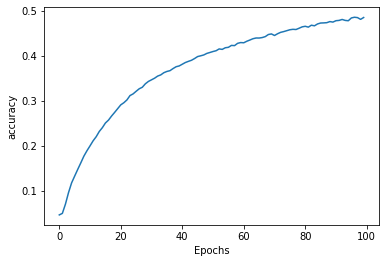

In [9]:
#plotting the graph
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [10]:
#generation of lyrics
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills the end of the park and homes all around and the bone and the bone and the things that make him see my ways to take me down to dreams you go and bobby other smokin tv light around and be deep inside the pain you magic spell where was a fellow hit every body room for the nights i love was so hard to hear a watch me you cant get you i gotta have to be home yonder thats love and you find me darling see me and you and me and pay the rich of your uncle


In [11]:
#varying possible outputs by switching from model.predict_classes to model.predict_proba
#by combining this with np.random.choice
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

1


In [12]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills me alone we know it from the worst i am the jet side black black nights i john can i got awake you bout me ahhah no no more you touch my knees got thing be shoes my own party up his kind space and now affairs or in pneumonia and travelled in phone crazy ball once morning that boogie you ball attraction this of all of me what what we can get right anywhere you opened up gonna be waiting at hand youve begun that forgotten stare jump ok wing doors club theres just what you was us so
